In [1]:
import pandas as pd
import numpy as np

In [2]:
bogota = pd.read_csv('bogota.csv')
bogota

,FECHA_DIAGNOSTICO,CASO,CASOS_ACUMULADOS,RECUPERADO,RECUPERADOS_ACUMULADOS,FALLECIDOS,FALLECIDOS_ACUMULADOS
0,2020-03-06,1,1,1,1,0,0
1,2020-03-07,0,1,0,1,0,0
2,2020-03-08,0,1,0,1,0,0
3,2020-03-09,0,1,0,1,0,0
4,2020-03-10,2,3,2,3,0,0
...,...,...,...,...,...,...,...
678,2022-01-13,8075,1565063,168,1484374,5,27949
679,2022-01-14,7942,1573005,174,1484548,1,27950
680,2022-01-15,6754,1579759,235,1484783,7,27957
681,2022-01-16,5333,1585092,31,1484814,2,27959


In [3]:
bogota_cases = bogota.drop(['CASO', 'RECUPERADO', 'RECUPERADOS_ACUMULADOS','FALLECIDOS','FALLECIDOS_ACUMULADOS'],axis=1)
bogota_cases

,FECHA_DIAGNOSTICO,CASOS_ACUMULADOS
0,2020-03-06,1
1,2020-03-07,1
2,2020-03-08,1
3,2020-03-09,1
4,2020-03-10,3
...,...,...
678,2022-01-13,1565063
679,2022-01-14,1573005
680,2022-01-15,1579759
681,2022-01-16,1585092


In [4]:
bogota_cases.set_index('FECHA_DIAGNOSTICO', inplace = True)
bogota_cases

,CASOS_ACUMULADOS
FECHA_DIAGNOSTICO,
2020-03-06,1
2020-03-07,1
2020-03-08,1
2020-03-09,1
2020-03-10,3
...,...
2022-01-13,1565063
2022-01-14,1573005
2022-01-15,1579759


In [5]:
train = bogota_cases[:138]
train

,CASOS_ACUMULADOS
FECHA_DIAGNOSTICO,
2020-03-06,1
2020-03-07,1
2020-03-08,1
2020-03-09,1
2020-03-10,3
...,...
2020-07-17,63192
2020-07-18,65655
2020-07-19,68127


In [6]:
test = bogota_cases[138:138+14]
test

,CASOS_ACUMULADOS
FECHA_DIAGNOSTICO,
2020-07-22,77437
2020-07-23,79880
2020-07-24,83604
2020-07-25,86717
2020-07-26,89002
2020-07-27,92710
2020-07-28,96653
2020-07-29,99736
2020-07-30,103354


In [7]:
from sklearn.preprocessing import MinMaxScaler

In [8]:
scaler = MinMaxScaler()
scaler.fit(train)

MinMaxScaler()

In [9]:
train_scaled =scaler.transform(train)
test_scaled = scaler.transform(test)

In [10]:
from keras.preprocessing.sequence import TimeseriesGenerator

In [11]:
window_size= 30
n_features= 1
batch_size = 1
train_generator = TimeseriesGenerator(train_scaled, train_scaled, length= window_size, batch_size=batch_size)
print("Total number of samples in the original training data = ", len(train))
print("Total number of samples in the generated data = ", len(train_generator))

Total number of samples in the original training data =  138
Total number of samples in the generated data =  108


In [12]:
x_train, y_train = train_generator[0]
x_train.shape
y_train.shape

(1, 1)

In [13]:
test_generator = TimeseriesGenerator(test_scaled, test_scaled, length=len(test)-1 ,batch_size=batch_size)
print("Total number of samples in the original training data = ", len(test))
print("Total number of sambles in the generated data", len(test_generator))

Total number of samples in the original training data =  14
Total number of sambles in the generated data 1


In [14]:
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout, Activation
from tensorflow.keras.optimizers import Adam 
from tensorflow.keras.metrics import RootMeanSquaredError

In [15]:
model = Sequential()
model.add(LSTM(300, activation='relu', return_sequences=True, input_shape=(window_size, n_features)))
model.add(LSTM(300, activation='relu'))
model.add(Dense(1))
model.compile(optimizer=Adam(learning_rate=0.0001), loss='mean_squared_error',metrics=[RootMeanSquaredError()])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 30, 300)           362400    
                                                                 
 lstm_1 (LSTM)               (None, 300)               721200    
                                                                 
 dense (Dense)               (None, 1)                 301       
                                                                 
Total params: 1,083,901
Trainable params: 1,083,901
Non-trainable params: 0
_________________________________________________________________


In [16]:
history=model.fit(train_generator, validation_data = test_generator, epochs=100)

Epoch 1/100
108/108 [==============================] - 17s 138ms/step - loss: 0.0535 - root_mean_squared_error: 0.2313 - val_loss: 0.2316 - val_root_mean_squared_error: 0.4812
Epoch 2/100
108/108 [==============================] - 16s 148ms/step - loss: 0.0016 - root_mean_squared_error: 0.0400 - val_loss: 0.4264 - val_root_mean_squared_error: 0.6530
Epoch 3/100
108/108 [==============================] - 16s 146ms/step - loss: 2.0749e-04 - root_mean_squared_error: 0.0144 - val_loss: 0.3665 - val_root_mean_squared_error: 0.6054
Epoch 4/100
108/108 [==============================] - 16s 152ms/step - loss: 1.2847e-04 - root_mean_squared_error: 0.0113 - val_loss: 0.3699 - val_root_mean_squared_error: 0.6082
Epoch 5/100
108/108 [==============================] - 15s 143ms/step - loss: 7.9559e-05 - root_mean_squared_error: 0.0089 - val_loss: 0.3957 - val_root_mean_squared_error: 0.6291
Epoch 6/100
108/108 [==============================] - 15s 141ms/step - loss: 9.4555e-05 - root_mean_squared

In [17]:
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1,len(loss)+1)

In [18]:
import matplotlib.pyplot as plt

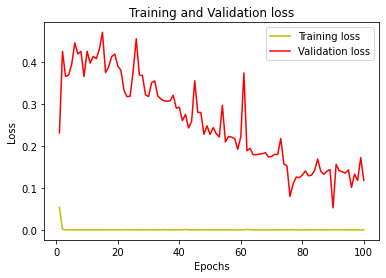

In [19]:
plt.plot(epochs, loss, 'y',label='Training loss')
plt.plot(epochs, val_loss, 'r',label='Validation loss')
plt.title('Training and Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

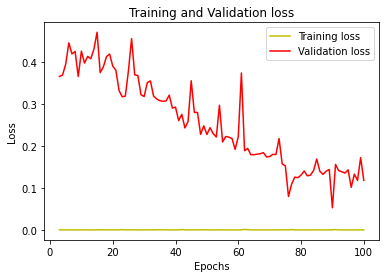

In [20]:
plt.plot(epochs[2:], loss[2:], 'y',label='Training loss')
plt.plot(epochs[2:], val_loss[2:], 'r',label='Validation loss')
plt.title('Training and Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [21]:
import numpy as np

predictions = []

first_batch = train_scaled[-window_size:]
current_batch = first_batch.reshape((1, window_size, n_features))


In [22]:
future = 60
for i in range(future):
    current_pred = model.predict(current_batch)[0]

    predictions.append(current_pred)
    
    current_batch_rmv_first = current_batch[:,1:,:]

    current_batch = np.append(current_batch_rmv_first,[[current_pred]], axis=1)

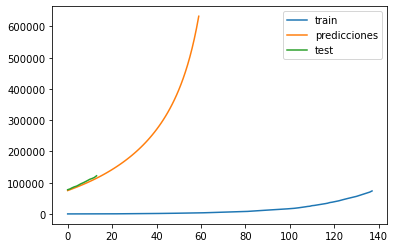

In [23]:
predictions_actual_scale = scaler.inverse_transform(predictions)
test_data_actual_scale = scaler.inverse_transform(test_scaled)
train_data_actual_scale =scaler.inverse_transform(train_scaled)

plt.plot(train_data_actual_scale, label='train')
plt.plot(predictions_actual_scale, label='predicciones')
plt.plot(test_data_actual_scale, label='test')
plt.legend()

In [24]:
test_prediction=model.predict(test_scaled)
test_prediction_data_actual_scale = scaler.inverse_transform(test_prediction)


In [25]:
train_data_actual_scale[:,0].shape

(138,)

In [26]:
rng1 = pd.date_range('2020-03-06', periods=138, freq='D')
rng1.shape

(138,)

In [27]:
df = pd.DataFrame({'Date':rng1,'train':train_data_actual_scale[:,0]})
df
df.set_index('Date', inplace = True)
df

,train
Date,
2020-03-06,1.0
2020-03-07,1.0
2020-03-08,1.0
2020-03-09,1.0
2020-03-10,3.0
...,...
2020-07-17,63192.0
2020-07-18,65655.0
2020-07-19,68127.0


In [28]:
rng2 = pd.date_range('2020-07-22', periods=len(test), freq='D')
rng2.shape

(14,)

In [29]:
df2 = pd.DataFrame({'Date':rng2,'Test':test_prediction_data_actual_scale[:,0]})
df2.set_index('Date', inplace = True)
df2

,Test
Date,
2020-07-22,4457.886719
2020-07-23,4537.964844
2020-07-24,4660.152344
2020-07-25,4762.352539
2020-07-26,4837.336914
2020-07-27,4959.086426
2020-07-28,5088.613281
2020-07-29,5189.988281
2020-07-30,5309.093750


In [30]:
predictions_actual_scale[:,0].shape

(60,)

In [31]:
rng3 = pd.date_range('2020-08-04', periods=future, freq='D')
rng3.shape

(60,)

In [36]:
df3 = pd.DataFrame({'Date':rng3,'Predictions':predictions_actual_scale[:,0]})
df3.set_index('Date', inplace = True)
df3

,Predictions
Date,
2020-08-04,74780.463940
2020-08-05,77405.544895
2020-08-06,80085.578008
2020-08-07,82824.902299
2020-08-08,85630.197229
2020-08-09,88505.810584
2020-08-10,91453.548098
2020-08-11,94475.338224
2020-08-12,97571.601717


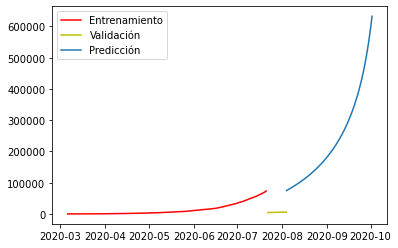

In [38]:
plt.plot(df,'r', label='Entrenamiento')
plt.plot(df2,'y', label='Validación')
plt.plot(df3, label='Predicción')
plt.legend()

In [42]:
dff = pd.DataFrame=({'Actual':test_data_actual_scale[:,0],'Prediction':test_prediction_data_actual_scale[:,0]})
dff

{'Actual': array([ 77437.,  79880.,  83604.,  86717.,  89002.,  92710.,  96653.,
         99736., 103354., 107086., 110960., 113427., 116606., 121973.]),
 'Prediction': array([4457.8867, 4537.965 , 4660.1523, 4762.3525, 4837.337 , 4959.0864,
        5088.6133, 5189.9883, 5309.0938, 5432.112 , 5559.983 , 5641.504 ,
        5746.654 , 5924.235 ], dtype=float32)}

In [44]:
import tensorflow as tf
mse = tf.keras.losses.MeanSquaredError()

In [45]:
mse(dff['Actual'],dff['Prediction'])

<tf.Tensor: shape=(), dtype=float32, numpy=8892020000.0>

In [43]:
dff1 = pd.DataFrame=({'Actual':test_scaled[:,0],'Prediction':test_prediction[:,0]})
dff1

{'Actual': array([1.05309253, 1.08631616, 1.13696078, 1.17929609, 1.21037099,
        1.26079802, 1.31442093, 1.35634826, 1.40555132, 1.45630474,
        1.50898928, 1.5425393 , 1.58577218, 1.65876081]),
 'Prediction': array([0.06061152, 0.06170055, 0.06336224, 0.06475212, 0.06577187,
        0.06742761, 0.06918911, 0.07056776, 0.07218754, 0.07386053,
        0.07559951, 0.07670815, 0.07813814, 0.08055316], dtype=float32)}

In [46]:
mse(dff1['Actual'],dff1['Prediction'])

<tf.Tensor: shape=(), dtype=float32, numpy=1.644552>